In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os
import datetime as dt
import pickle

from utils import processing
from utils import utils

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, \
    BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import wandb
from wandb.keras import WandbCallback


In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,12)

In [4]:
random.seed(hash("random seed") % 2**32 - 1)
np.random.seed(hash("numpy seed") % 2**32 - 1)
tf.random.set_seed(hash("tensorflow seed") % 2**32 - 1)

In [5]:
wandb.login()

wandb: Currently logged in as: nbvanting (use `wandb login --relogin` to force relogin)


True

In [6]:
def metrics(true, pred):
    print(f'MSE: {np.mean(mean_squared_error(true, pred))}')
    print(f'RMSE: {np.sqrt(np.mean(mean_squared_error(true, pred)))}')
    print(f'MAE: {np.mean(mean_absolute_error(true, pred))}')
    print(f'MAPE: {np.mean(mean_absolute_percentage_error(true, pred))}')
    
    
def load_data(config, splitmethod):
    # Load csv & parse dates to datetime index
    data = pd.read_csv(f'../data/processed/{config.dataset}_features.csv', index_col='Datetime', parse_dates=['Datetime'])
    # Select Features
    data = data[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]
    
    if splitmethod == 'offset':
        train, val, test = processing.ts_offset_split(data, 
                                  steps=steps, lookback=config.lookback, 
                                  horizon=horizon, batch_size=config.batch_size, 
                                  scaler='standard')
    
    elif splitmethod == 'standard':
        train, val, test = processing.create_datasets(data, split=config.splitrate, 
                                  steps=steps, lookback=config.lookback, 
                                  horizon=horizon, batch_size=config.batch_size, 
                                  scaler='standard')
    
    return train, val, test
    
    
def build_model(config):
        
    model = Sequential(name='Hybrid-CNNRNN-Kolding')

    model.add(Input(shape=(config.lookback, config.num_features), name='InputLayer'))

    # CNN Block
    model.add(Conv1D(filters=config.cnn_layer_size_1, kernel_size=config.kernelsize, activation=config.activation_cnn, name='ConvolutionalLayer'))
    model.add(MaxPooling1D(pool_size=2, name='MaxPoolingLayer'))
    
    # RNN Block  
    model.add(GRU(config.gru_layer_size_1, return_sequences=False, activation=config.activation_gru, name='GRURecurrentLayer'))
    model.add(Dropout(config.dropout, name='Dropout'))

    model.add(Dense(1, name='OutputLayer'))
    
    opt = config.optimizer
    if opt == 'sgd':
        optimizer = SGD(learning_rate=config.learning_rate, momentum=config.momentum)
        
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

def log_defaults():
    # Default values from the first sweep
    # The following values resulted in the strongest model
    wandb_config = {
        'num_features' : 9,
        'epochs' : 100,
        'batch_size' : 224,
        'optimizer' : 'sgd',
        'dropout' : 0.2,
        'lookback' : 744,
        'activation_cnn' : 'relu',
        'activation_gru' : 'tanh',
        'kernelsize': 3,
        'cnn_layer_size_1' : 56,
        'gru_layer_size_1' : 96,
        'learning_rate' : 0.04,
        'momentum' : 0.9,
        'dataset' : 'kolding',
        'splitmethod': 'offset',
    }
    return wandb_config



In [7]:
# Additional Parameters
steps = 1 # timesteps: 1 hour
horizon = 1 # the target hour in the future we want to predict 1 hour ahead


In [8]:
# Find Scaled Values Std for Inverse Scaling later on
kld_data = pd.read_csv(f'../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])

start = 0
end = 168
offset = 24
training = []
validation = []

for i in range(int((365+366)/8)):

    kld_train = kld_data.iloc[start:end]
    kld_val = kld_data.iloc[end:end+offset]
    training.append(kld_train)
    validation.append(kld_val)

    start += 192
    end += 192

# Decide Splits for sets
kld_train = pd.concat(training)

kld_val = pd.concat(validation)
kld_train = kld_train.append(kld_data[(kld_data.index.date > kld_val.index.max()) & (kld_data.index.date < dt.date(2021,1,1))])

kld_test = kld_data[kld_data.index.date >= dt.date(2021,1,1)]

train_floats = kld_train[['Value']].to_numpy()
train_mean = train_floats.mean(axis=0)
train_floats -= train_mean
train_std = train_floats.std(axis=0)
train_floats /= train_std

print(f'Standardized Mean: {train_mean},\nStandardized Std: {train_std},\nStandardized Head: {train_floats[:5]}')

Standardized Mean: [87.50684772],
Standardized Std: [31.31291841],
Standardized Head: [[ 0.92023209]
 [ 0.48459719]
 [ 0.2833384 ]
 [-0.06881657]
 [-0.40446079]]


In [9]:
wandb.init(config=log_defaults(), group='cnnrnn-final-train-kolding', project='thesis')

model = build_model(config=wandb.config)

train, val, test = load_data(config=wandb.config, splitmethod=wandb.config.splitmethod)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5)

ckpt_path = "../model/models/cnngru_final-kolding.h5"
estp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

callbacks = [WandbCallback(), reduce_lr, ckpt, estp]

c:\users\nicol\envs\thesis\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
history = model.fit(
    train,
    epochs=wandb.config.epochs,
    validation_data=val,
    callbacks=callbacks
)

eval = model.evaluate(test)
wandb.log({'test_loss': eval[0]})
wandb.log({'test_mae': eval[1]})
print(f'\nTest Loss: {eval[0]} - Test MAE: {eval[1]}')

In [10]:
wandb.finish()

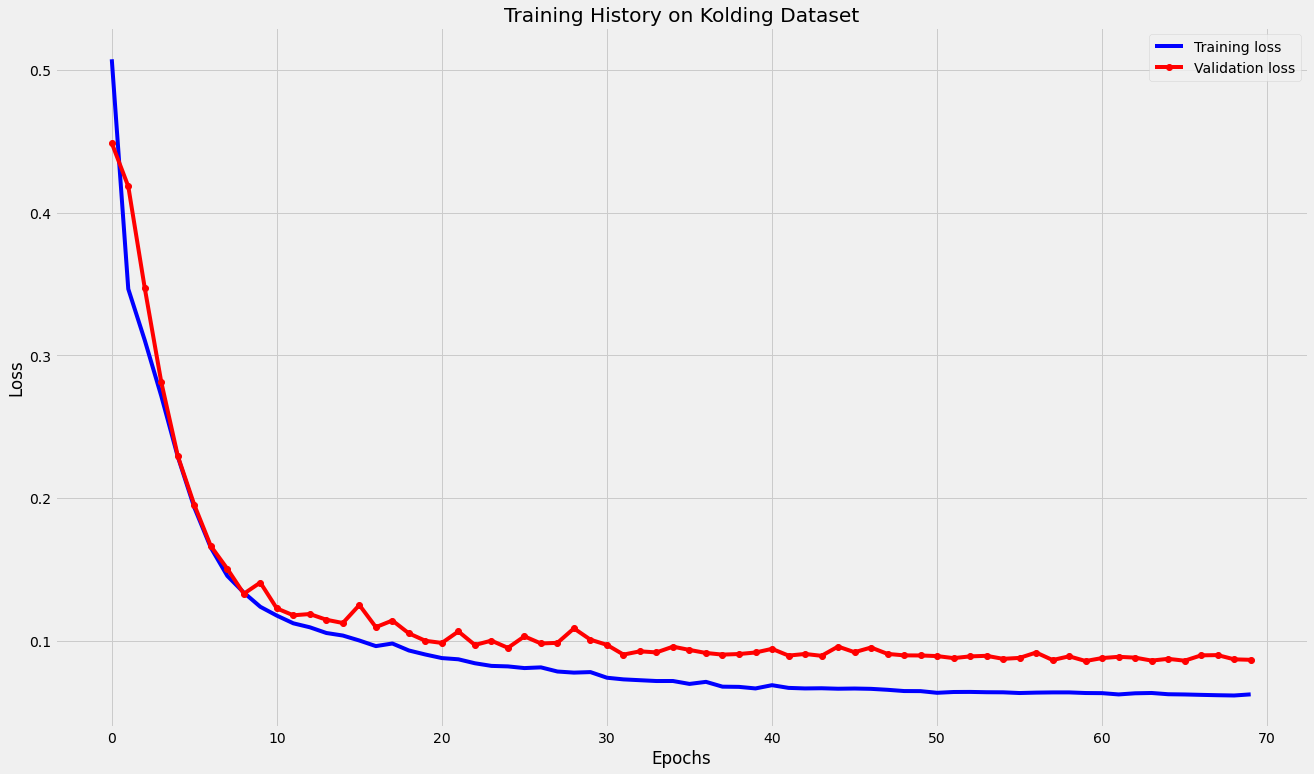

In [11]:
utils.plot_training(history, 'Training History on Kolding Dataset')

## Saving & Loading History & Model

In [41]:
with open('../model/models/training_hist/kolding', 'wb') as f:
    pickle.dump(history.history, f)

In [9]:
with open('../model/models/training_hist/kolding', 'rb') as f:
    hist = pickle.load(f)

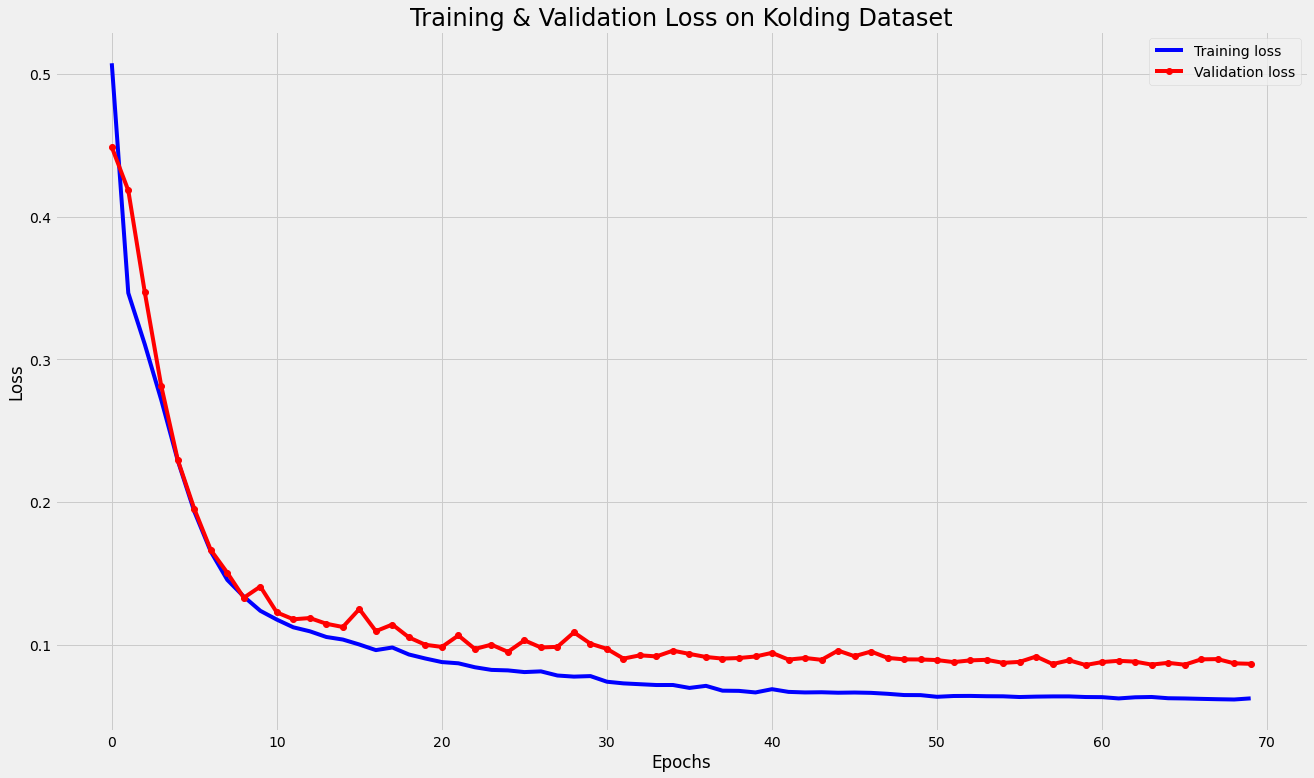

In [11]:
loss = hist["loss"]
val_loss = hist["val_loss"]

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "ro-", label="Validation loss")
plt.title('Training & Validation Loss on Kolding Dataset', fontsize=24)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('visuals/train_hist_kolding_hybrid.png', bbox_inches='tight')
plt.show()

In [23]:
min_loss = min(hist['val_loss'])
hist['val_loss'].index(min_loss)

59

In [20]:
min(hist['val_loss'])

0.08578574657440186

In [11]:
model.load_weights(ckpt_path)

In [12]:
model.evaluate(test)

7/7 [==============================] - 2s 191ms/step - loss: 0.1607 - mae: 0.3038


[0.1375889629125595, 0.2812016010284424]

In [19]:
import pydot
import pydotplus
from pydotplus import graphviz
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

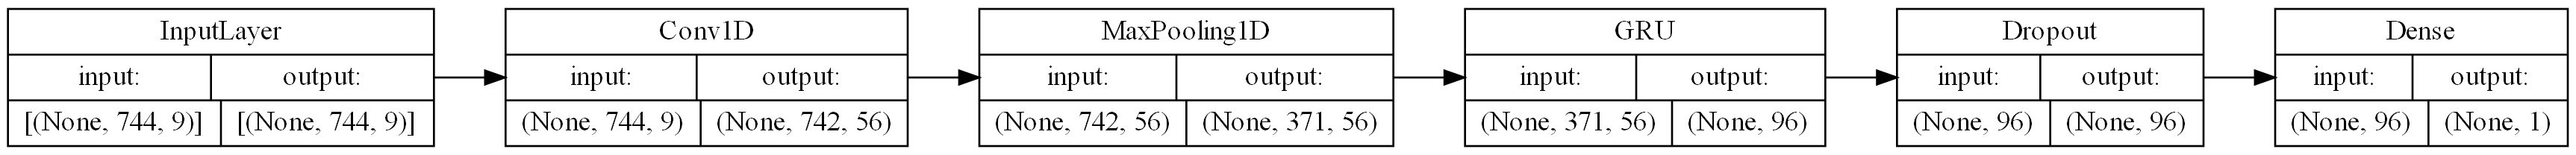

In [24]:
# Model Architecture Plot
plot_model(model, 
           to_file='visuals/kolding_model_architecture.png', 
           show_shapes=True, show_layer_names=False, 
           show_dtype=False, rankdir='LR',
           expand_nested=True, dpi=192
           )

## Evaluation & Plotting

In [13]:
def get_metrics(true, pred):
    mse = np.mean(mean_squared_error(true, pred))
    rmse = np.sqrt(np.mean(mean_squared_error(true, pred)))
    mae = np.mean(mean_absolute_error(true, pred))
    mape = np.mean(mean_absolute_percentage_error(true, pred))
    return mse, rmse, mae, mape

In [12]:
pred = model.predict(test)
inverse_scaled_pred = (pred * train_std) + train_mean
inverse_scaled_pred

y_true = kld_test.iloc[744+1:len(kld_test) - 744 + 1][['Value']]

pred_df = y_true.copy()
pred_df.rename(columns={'Value':'True'}, inplace=True)
pred_df['Pred'] = inverse_scaled_pred

In [15]:
y_true.to_csv('y_true_kolding.csv', header=True, index_label='Datetime')

In [14]:
metrics(y_true.values, inverse_scaled_pred)

MSE: 123.47971429715669
RMSE: 11.112142651044248
MAE: 8.516255358435847
MAPE: 8.115259223379361


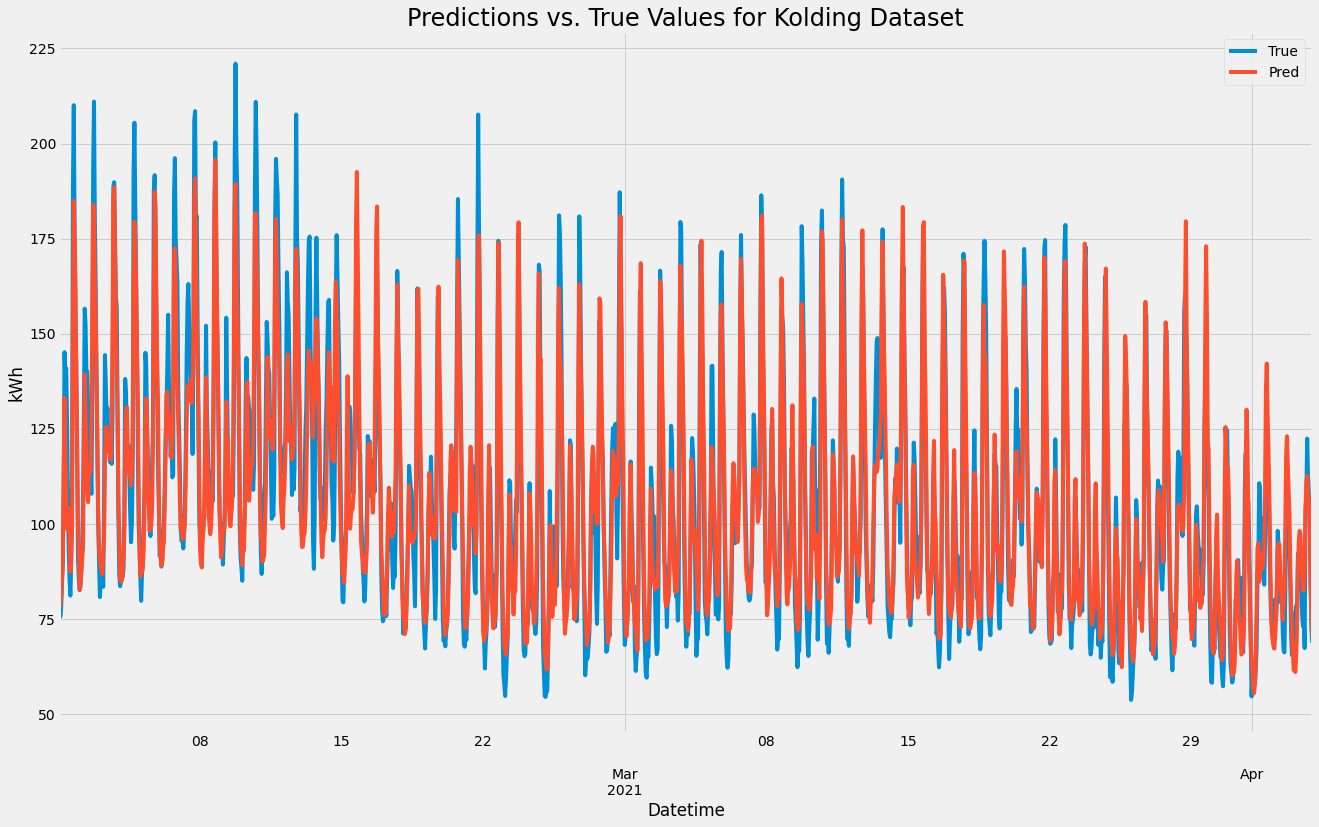

In [26]:
ax = pred_df.plot()
ax.set_title('Predictions vs. True Values for Kolding Dataset', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_vs_true_full_kolding.png', bbox_inches='tight')
plt.show()

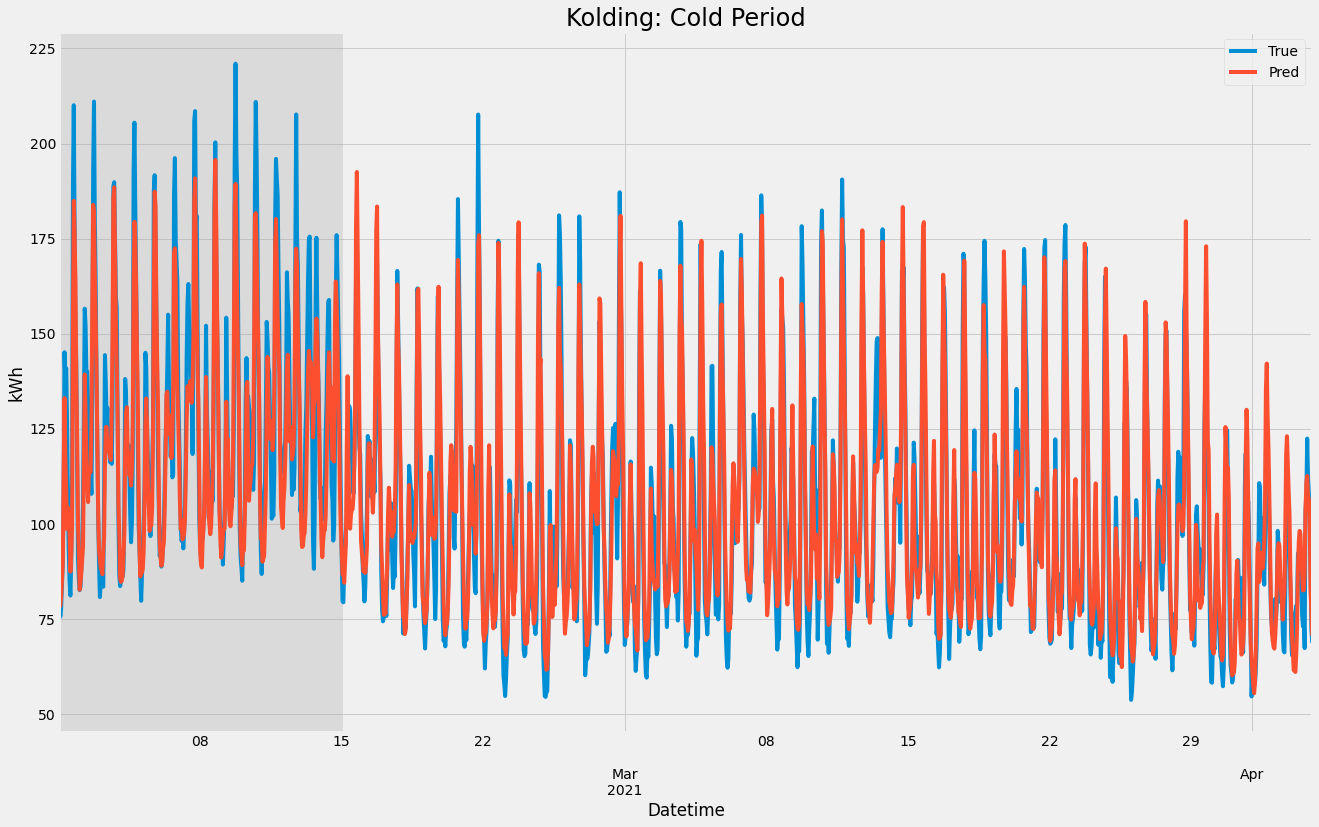

In [59]:
ax = pred_df.plot()
ax.set_title('Kolding: Cold Period', fontsize=24)
ax.set_ylabel('kWh')
ax.axvspan(dt.date(2021, 2, 1), dt.date(2021, 2, 15), color='darkgrey', alpha=.3)
plt.savefig('visuals/pred_cold_period_full_kolding.png', bbox_inches='tight')
plt.show()

During the first half of Feb, 2021 there was an extraordinarily cold period. The temperature hit close to -10 degrees celsius. The below predictions show the performance of the model on that particular period.

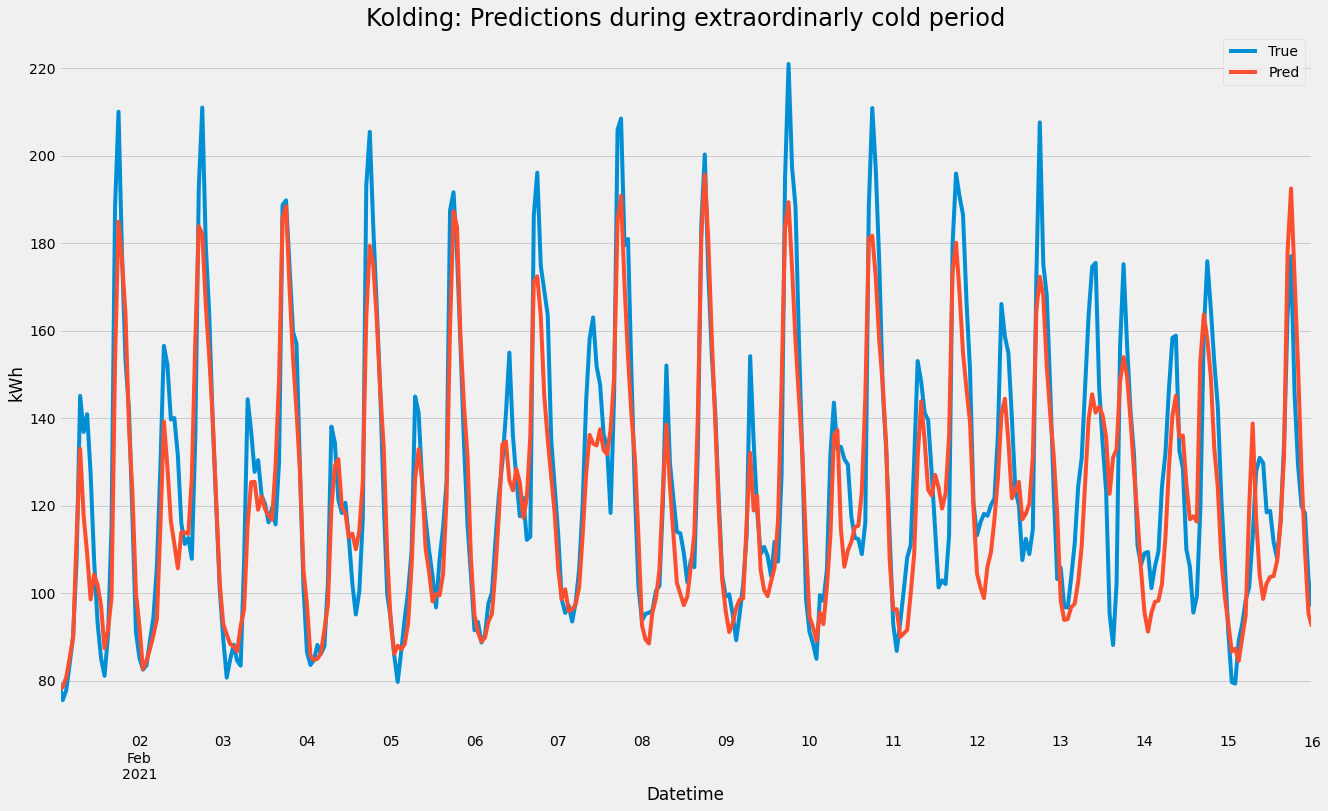

In [64]:
ax = pred_df.loc[dt.date(2021, 2, 1):dt.date(2021, 2, 16)].plot()
ax.set_title('Kolding: Predictions during extraordinarly cold period', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_cold_period_kolding.png', bbox_inches='tight')
plt.show()

In [14]:
cold_period = pred_df.loc[dt.date(2021, 2, 1):dt.date(2021, 2, 16)]
metrics(cold_period['True'], cold_period['Pred'])

MSE: 190.8041276065719
RMSE: 13.813186728867887
MAE: 10.638010406728748
MAPE: 8.149609605270832


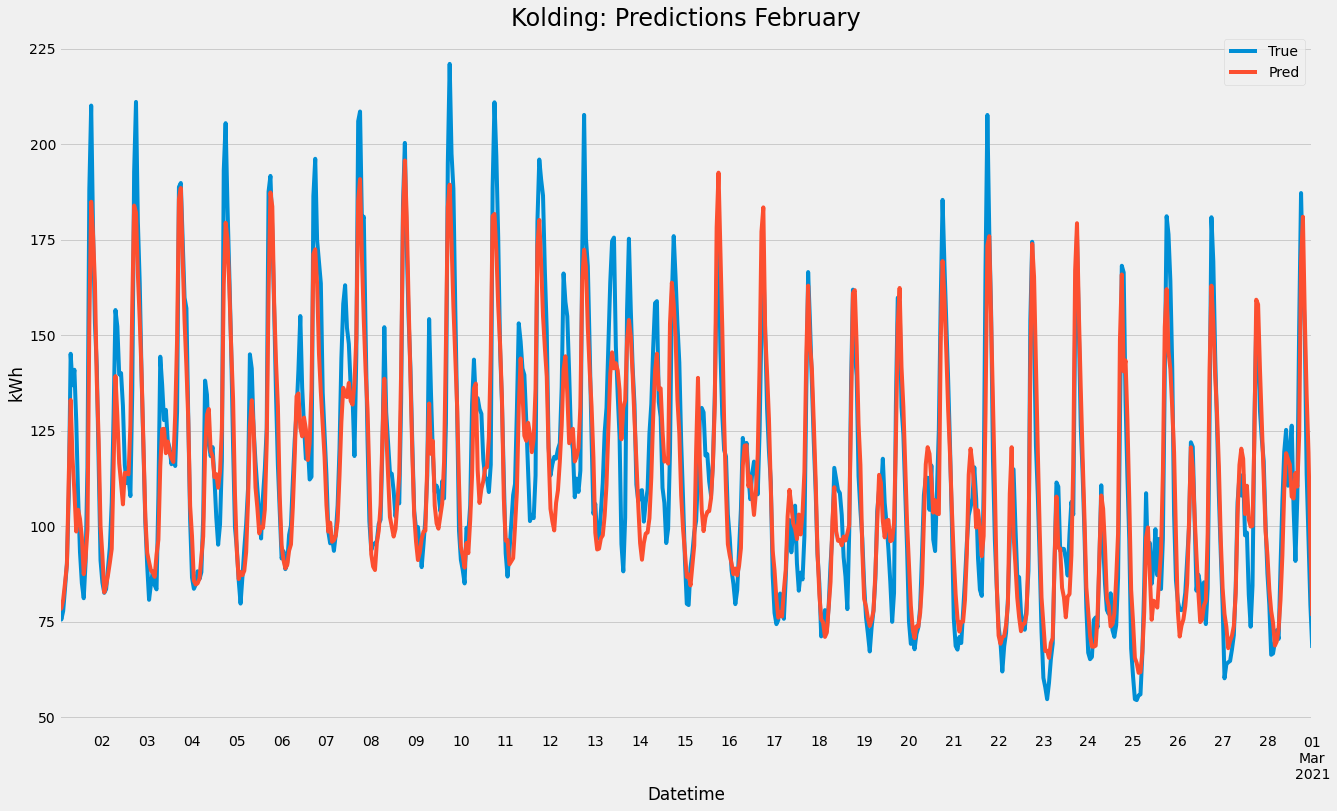

In [63]:
ax = pred_df.loc[dt.date(2021, 2, 1):dt.date(2021, 3, 1)].plot()
ax.set_title('Kolding: Predictions February', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_february_kolding.png', bbox_inches='tight')
plt.show()

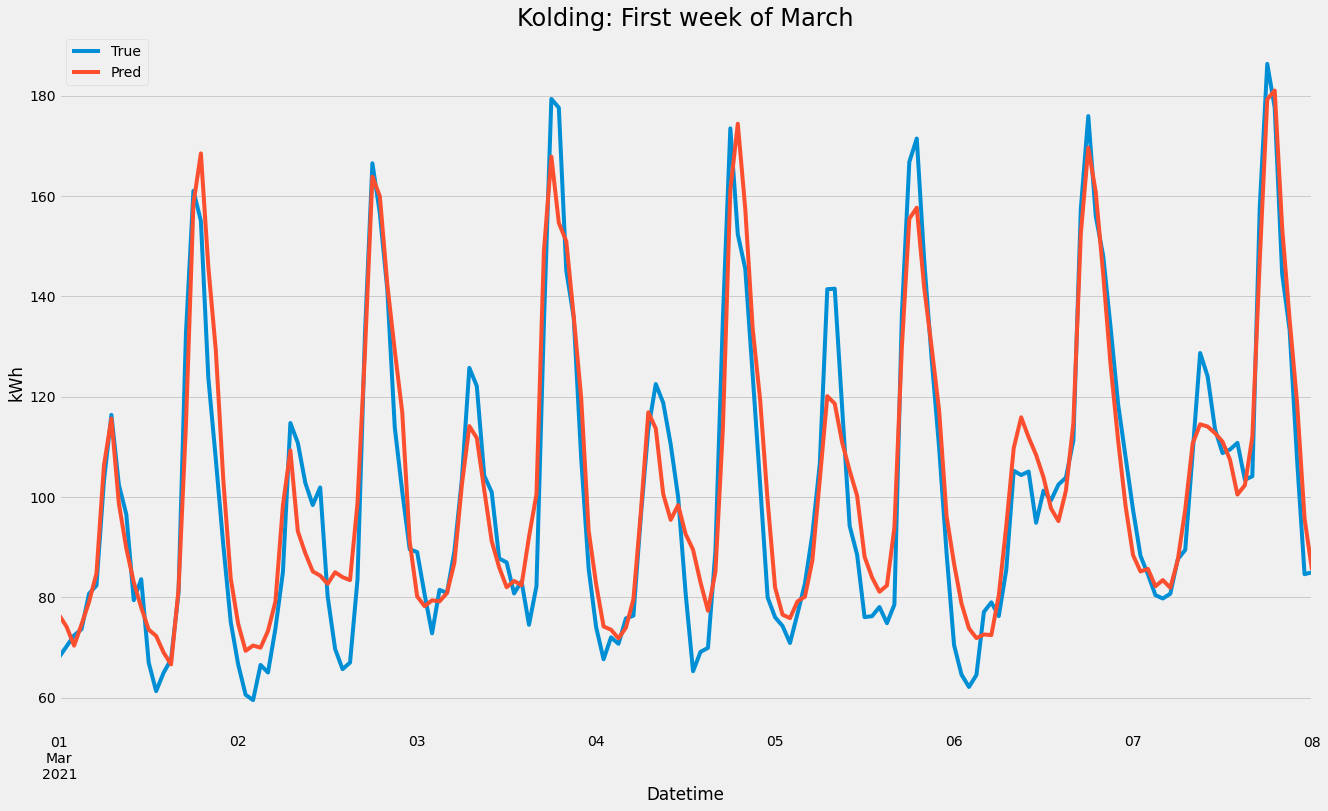

In [62]:
ax = pred_df.loc[dt.date(2021, 3, 1):dt.date(2021, 3, 8)].plot()
ax.set_title('Kolding: First week of March', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_1weekmarch_kolding.png', bbox_inches='tight')
plt.show()

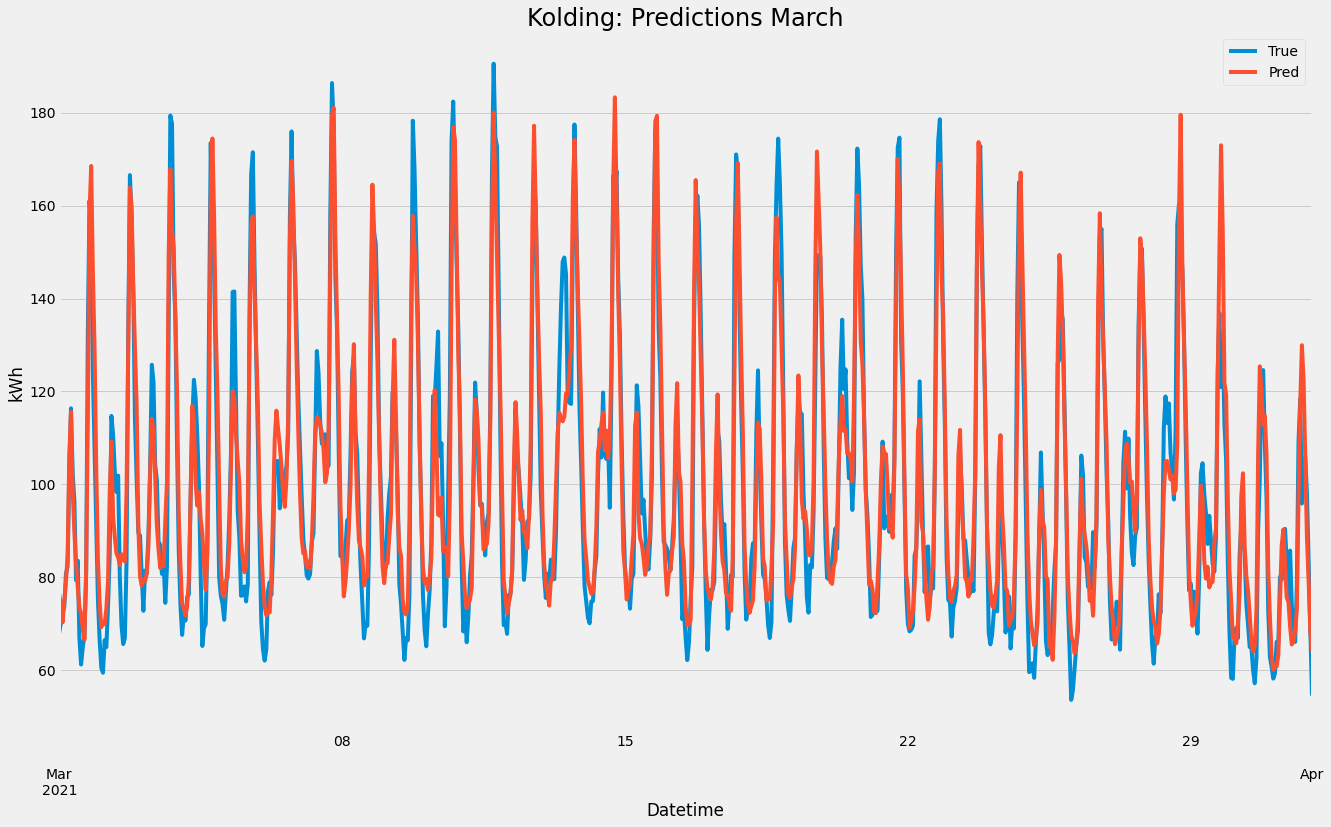

In [61]:
ax = pred_df.loc[dt.date(2021, 3, 1):dt.date(2021, 4, 1)].plot()
ax.set_title('Kolding: Predictions March', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_march_kolding.png', bbox_inches='tight')
plt.show()

Ideas for plots:
- week 7
- find special holidays
        Palmesøndag 28. marts 2021.
        Skærtorsdag 01. april 2021.
        Langfredag 02. april 2021.
- which days can the model predict well / not so well ? 
- 

# Holidays

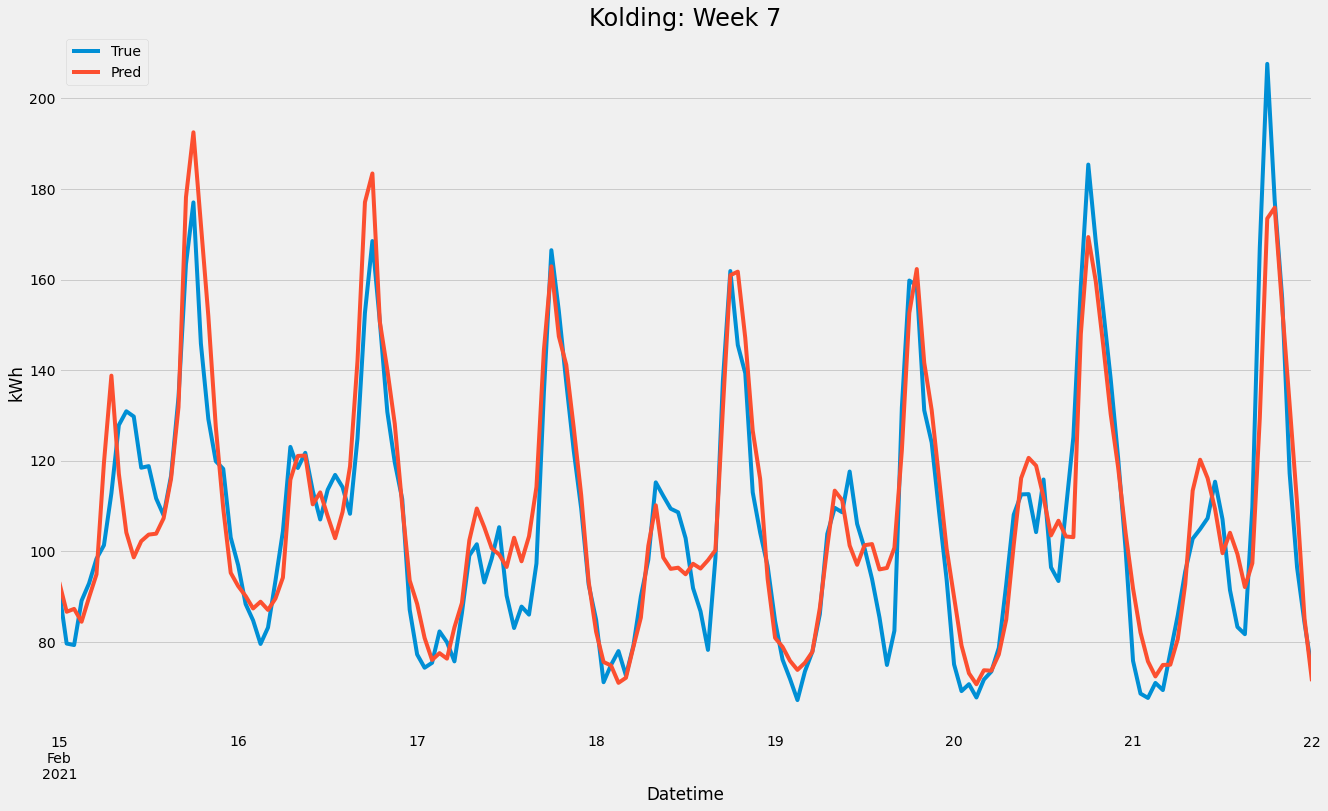

In [41]:
ax = pred_df.loc[dt.date(2021, 2, 15):dt.date(2021, 2, 22)].plot()
ax.set_title('Kolding: Week 7', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_week7_kolding.png', bbox_inches='tight')
plt.show()

In [15]:
week7 = pred_df.loc[dt.date(2021, 2, 15):dt.date(2021, 2, 22)]
metrics(week7['True'].values, week7['Pred'].values)

MSE: 117.91097712598477
RMSE: 10.858682108155886
MAE: 8.36882276555416
MAPE: 7.882188029912962


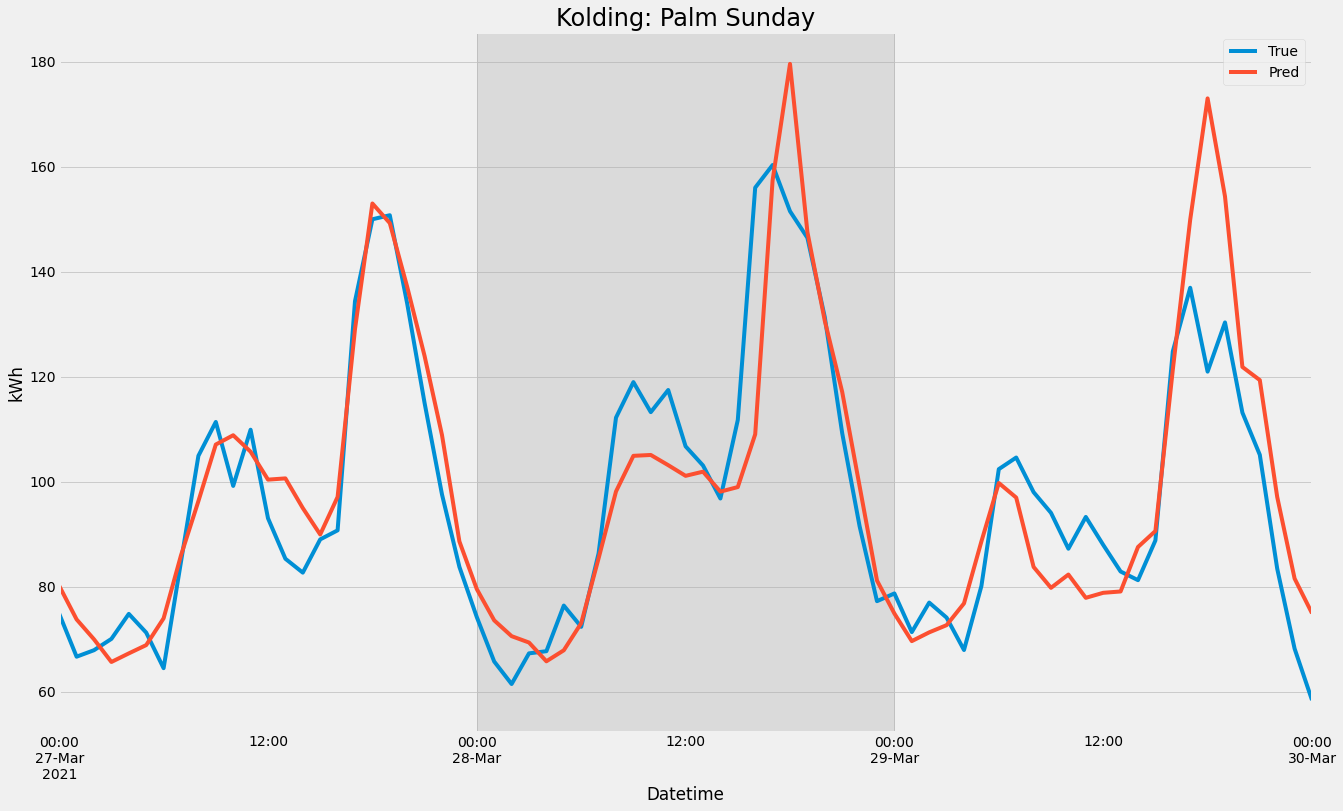

In [20]:
ax = pred_df.loc[dt.date(2021, 3, 27):dt.date(2021, 3, 30)].plot()
ax.set_title('Kolding: Palm Sunday', fontsize=24)
ax.set_ylabel('kWh')
ax.axvspan(dt.date(2021, 3, 28), dt.date(2021, 3, 29), color='darkgrey', alpha=.3)
plt.savefig('visuals/pred_palmsunday_kolding.png', bbox_inches='tight')
plt.show()

In [17]:
palmsunday = pred_df.loc[dt.date(2021, 3, 28):dt.date(2021, 3, 29)]
metrics(palmsunday['True'].values, palmsunday['Pred'].values)

MSE: 170.9780978569667
RMSE: 13.075859354435055
MAE: 8.43750986067586
MAPE: 7.731698563922502


Palmsunday on the 28th of march seemed to affect the models ability to predict the next 29th, which is a monday.

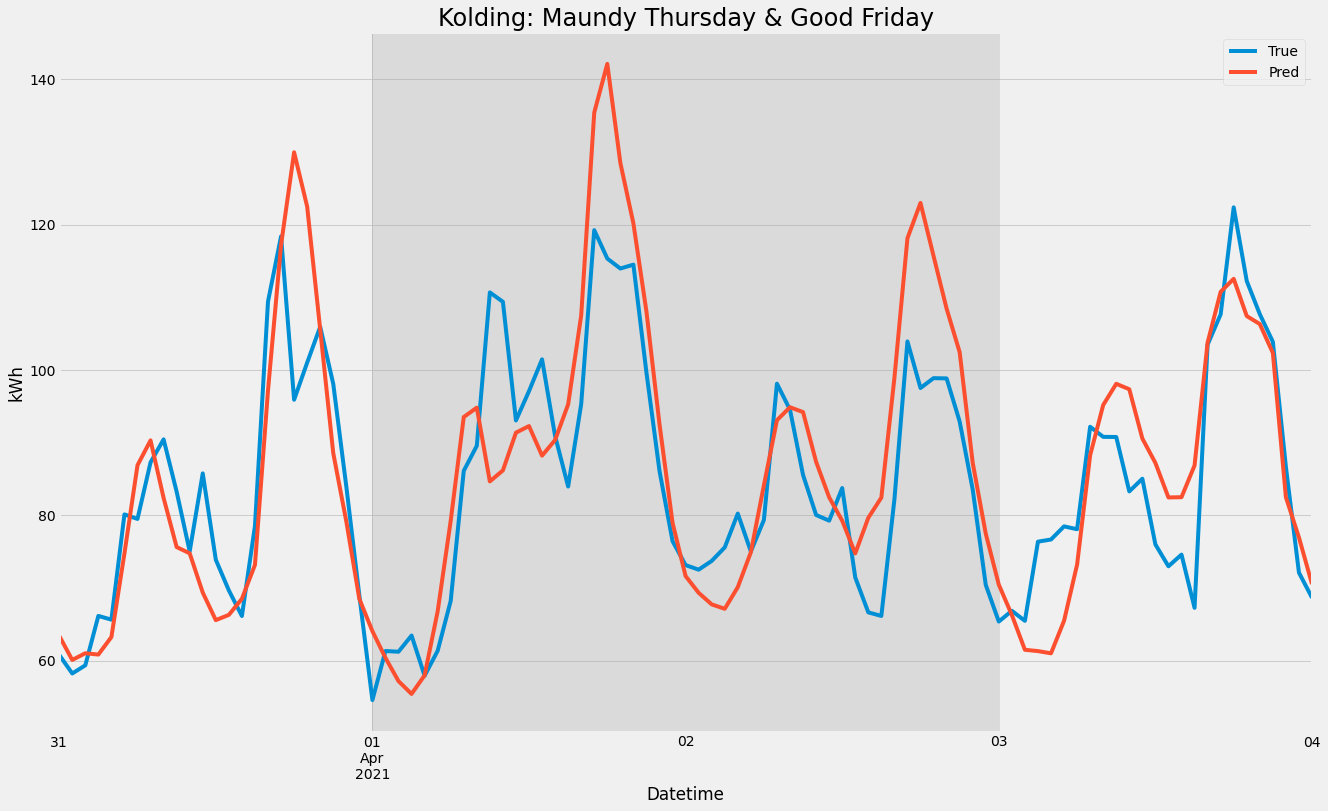

In [19]:
ax = pred_df.loc[dt.date(2021, 3, 31):dt.date(2021, 4, 4)].plot()
ax.set_title('Kolding: Maundy Thursday & Good Friday', fontsize=24)
ax.set_ylabel('kWh')
ax.axvspan(dt.date(2021, 4, 1), dt.date(2021, 4, 3), color='darkgrey', alpha=.3)
plt.savefig('visuals/pred_goodfriday_kolding.png', bbox_inches='tight')
plt.show()

In [18]:
goodfriday = pred_df.loc[dt.date(2021, 4, 1):dt.date(2021, 4, 3)]
metrics(goodfriday['True'].values, goodfriday['Pred'].values)

MSE: 122.52268286816741
RMSE: 11.068996470690891
MAE: 8.76106238190985
MAPE: 9.996574700767152


In [22]:
(8.76106238190985 + 8.43750986067586 + 8.36882276555416) / 3

8.522465002713291

## Predicting certain days

In [16]:
pred_days = pred_df.index.weekday.unique().tolist()

for d in pred_days:
    day_df = pred_df[pred_df.index.weekday == d]
    print(f'Day: {d}')
    metrics(day_df['True'].values, day_df['Pred'].values)
    print('\n')

Day: 0
MSE: 123.17877292807425
RMSE: 11.09859328600135
MAE: 8.221115590494394
MAPE: 7.673249487090588


Day: 1
MSE: 112.57086729855163
RMSE: 10.609941908349528
MAE: 8.315772914643553
MAPE: 8.245909501890356


Day: 2
MSE: 122.0820772498016
RMSE: 11.049075855011658
MAE: 8.448157558324205
MAPE: 8.286514394804492


Day: 3
MSE: 136.89352000439902
RMSE: 11.700150426571405
MAE: 9.257070156247169
MAPE: 8.974894591001808


Day: 4
MSE: 93.94454616559912
RMSE: 9.692499479783278
MAE: 7.583680072468968
MAPE: 7.364006105206696


Day: 5
MSE: 133.55556561057992
RMSE: 11.556624317272753
MAE: 8.735445978860593
MAPE: 8.231106411468412


Day: 6
MSE: 144.35398035017636
RMSE: 12.014740128283107
MAE: 9.114926209319375
MAPE: 8.01881858922131




In [63]:
day_metrics = []

for d in pred_days:
    day_df = pred_df[pred_df.index.weekday == d]
    day_metrics.append(get_metrics(day_df['True'].values, day_df['Pred'].values))
    
day_rmse = [rmse for (_, rmse, _, _) in day_metrics]
day_mae = [mae for (_, _, mae, _) in day_metrics]
day_mape = [mape for (_, _, _, mape) in day_metrics]

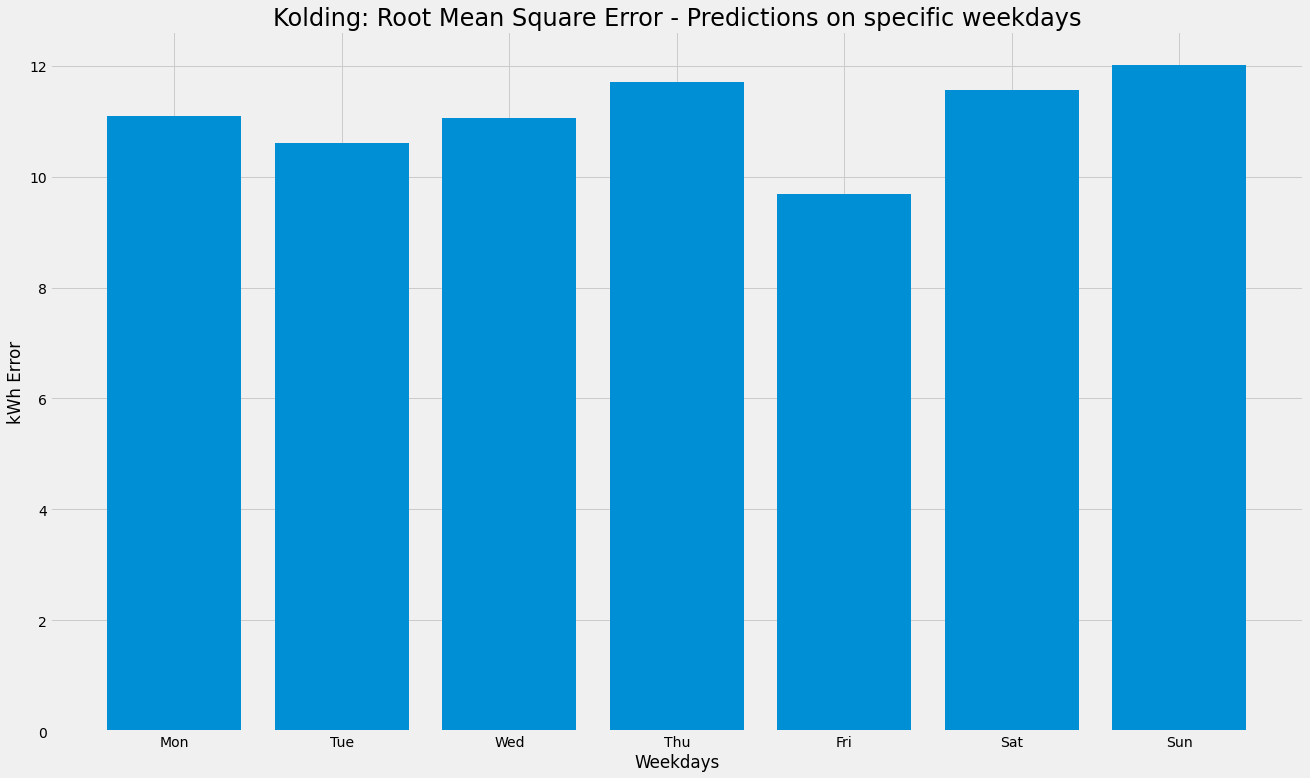

In [90]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(days, height=day_rmse)
plt.title('Kolding: Root Mean Square Error - Predictions on specific weekdays', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Weekdays')
plt.savefig('visuals/kolding_rmse_weekday.png', bbox_inches='tight')
plt.show()

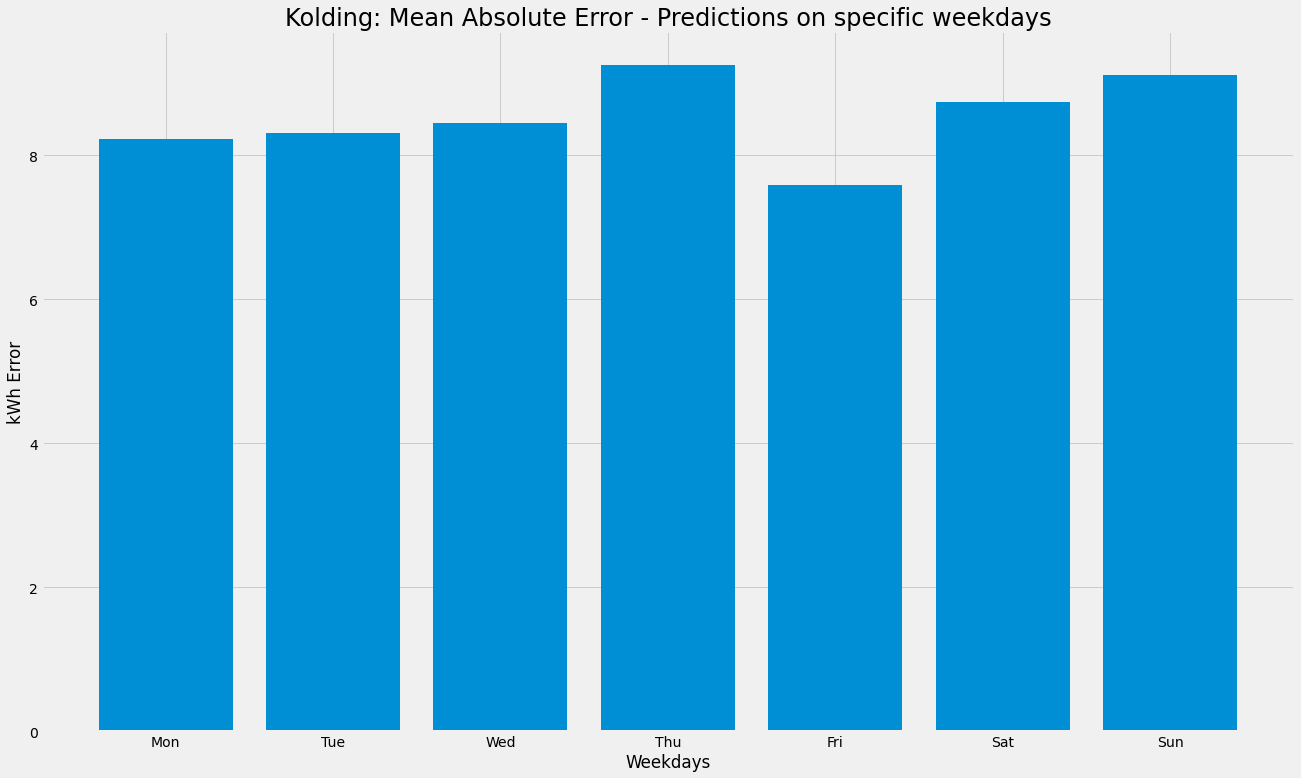

In [91]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(days, height=day_mae)
plt.title('Kolding: Mean Absolute Error - Predictions on specific weekdays', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Weekdays')
plt.savefig('visuals/kolding_mae_weekday.png', bbox_inches='tight')
plt.show()

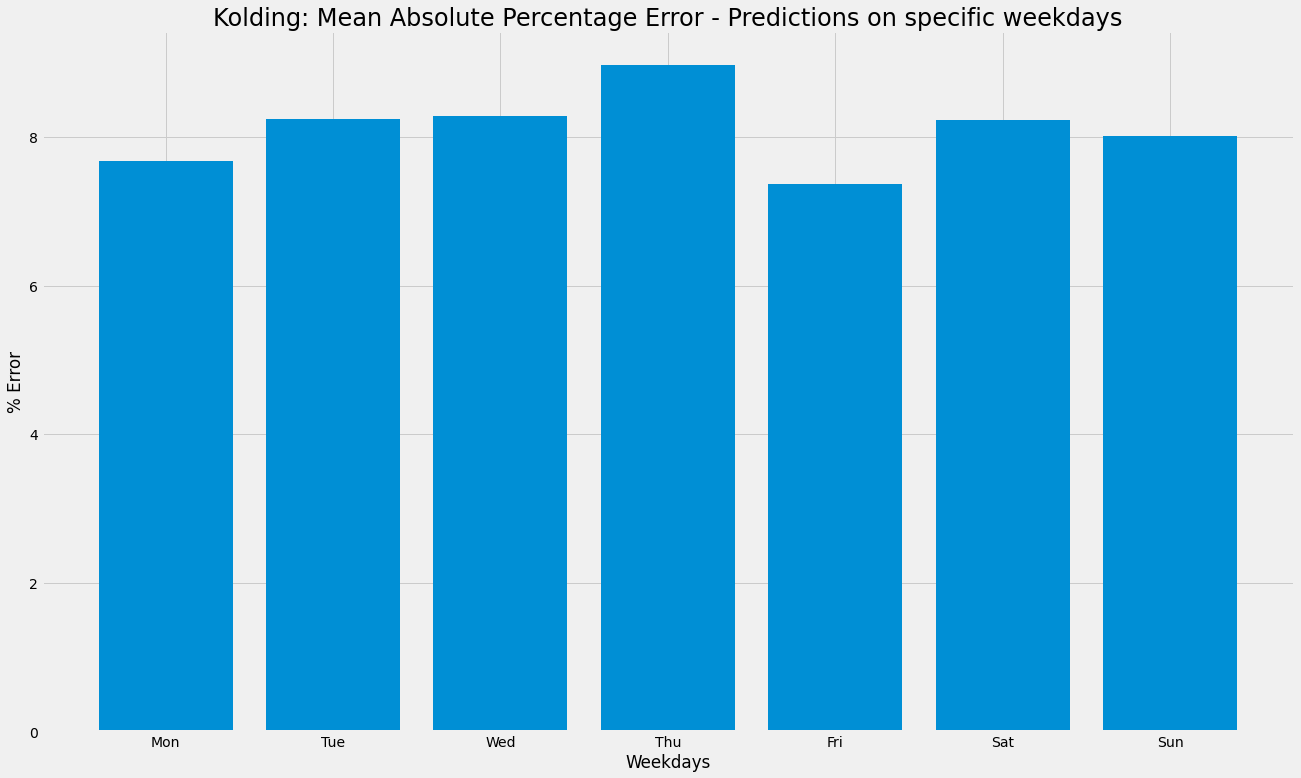

In [92]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(days, height=day_mape)
plt.title('Kolding: Mean Absolute Percentage Error - Predictions on specific weekdays', fontsize=24)
plt.ylabel('% Error')
plt.xlabel('Weekdays')
plt.savefig('visuals/kolding_mape_weekday.png', bbox_inches='tight')
plt.show()

## Predicting certain months


In [57]:
pred_months = pred_df.index.month.unique().tolist()

for m in pred_months:
    month_df = pred_df[pred_df.index.month == m]
    print(f'Month: {m}')
    print(f'Number of days in Month: {len(month_df.index.day.unique())}')
    metrics(month_df['True'].values, month_df['Pred'].values)
    print('\n')

Month: 2
Number of days in Month: 28
MSE: 153.35331550660774
RMSE: 12.38359057408665
MAE: 9.571257388730514
MAPE: 8.2837432329116


Month: 3
Number of days in Month: 31
MSE: 98.11357213490821
RMSE: 9.905229534690664
MAE: 7.597062296368877
MAPE: 7.818398475266805


Month: 4
Number of days in Month: 4
MSE: 107.41428083374838
RMSE: 10.364086107021128
MAE: 8.187122150903058
MAPE: 9.592130815154833




In [75]:
month_metrics = []

for m in pred_months:
    month_df = pred_df[pred_df.index.month == m]
    month_metrics.append(get_metrics(month_df['True'].values, month_df['Pred'].values))
    
month_rmse = [rmse for (_, rmse, _, _) in month_metrics]
month_mae = [mae for (_, _, mae, _) in month_metrics]
month_mape = [mape for (_, _, _, mape) in month_metrics]

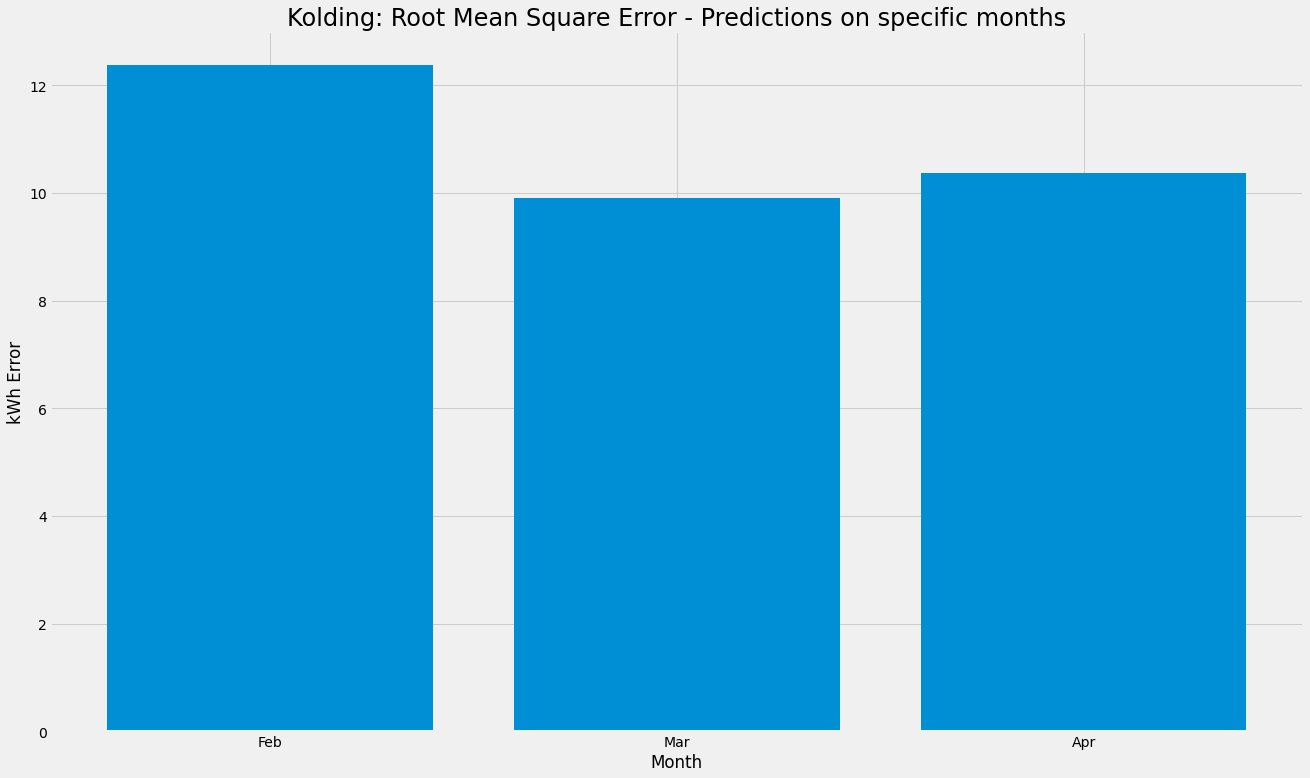

In [93]:
months = ['Feb', 'Mar', 'Apr']

plt.bar(months, height=month_rmse)
plt.title('Kolding: Root Mean Square Error - Predictions on specific months', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Month')
plt.savefig('visuals/kolding_rmse_month.png', bbox_inches='tight')
plt.show()

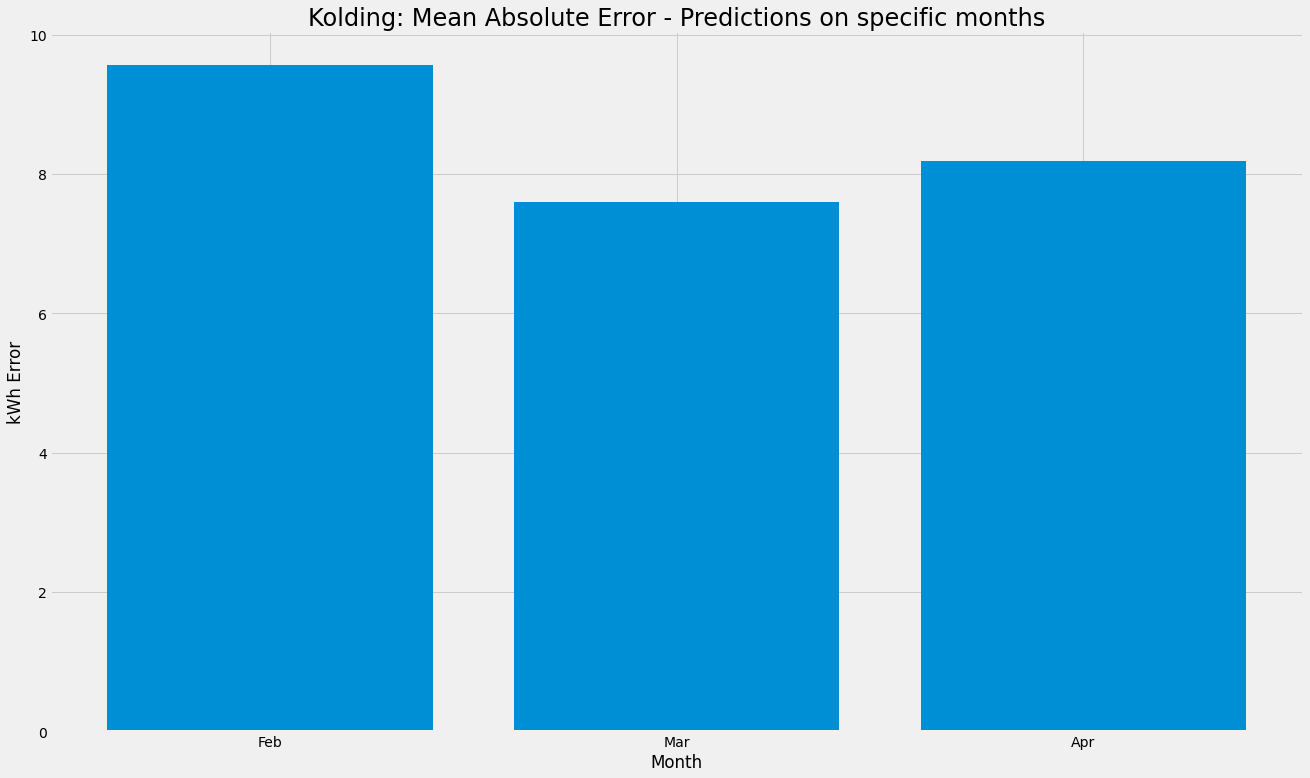

In [94]:
plt.bar(months, height=month_mae)
plt.title('Kolding: Mean Absolute Error - Predictions on specific months', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Month')
plt.savefig('visuals/kolding_mae_month.png', bbox_inches='tight')
plt.show()

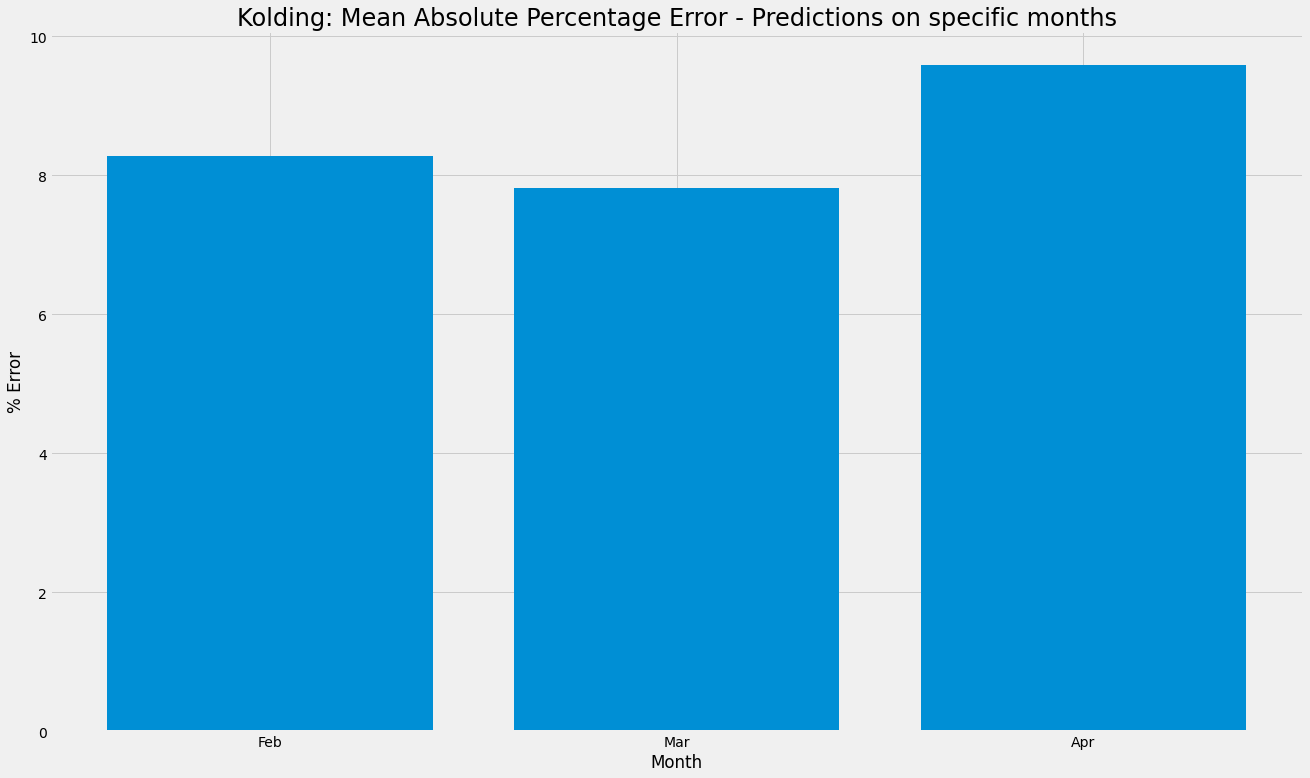

In [95]:
plt.bar(months, height=month_mape)
plt.title('Kolding: Mean Absolute Percentage Error - Predictions on specific months', fontsize=24)
plt.ylabel('% Error')
plt.xlabel('Month')
plt.savefig('visuals/kolding_mape_month.png', bbox_inches='tight')
plt.show()

## Predicting certain weeks

In [58]:
pred_weeks = pred_df.index.week.unique().tolist()

for w in pred_weeks:
    week_df = pred_df[pred_df.index.week == w]
    print(f'Week: {w}')
    metrics(week_df['True'].values, week_df['Pred'].values)
    print('\n')

Week: 5
MSE: 159.21111953765867
RMSE: 12.617888870078808
MAE: 9.243798653036624
MAPE: 6.927598094912005


Week: 6
MSE: 218.3760581978185
RMSE: 14.7775525104064
MAE: 11.869969216507029
MAPE: 9.132636532848906


Week: 7
MSE: 118.58131984904784
RMSE: 10.88950503232575
MAE: 8.404942312158957
MAPE: 7.910506230556436


Week: 8
MSE: 117.27963232304316
RMSE: 10.829572120958574
MAE: 8.764370214078413
MAPE: 9.156159780840968


Week: 9
MSE: 98.20471566135113
RMSE: 9.909829244813007
MAE: 7.930651923700869
MAPE: 8.275421266351316


Week: 10
MSE: 105.49064965294565
RMSE: 10.270864114228445
MAE: 7.802024382299275
MAPE: 7.527145840782397


Week: 11
MSE: 86.98961277339394
RMSE: 9.32682222267552
MAE: 7.452699017513668
MAPE: 7.251701586023785


Week: 12
MSE: 84.34530446945134
RMSE: 9.183969973244213
MAE: 6.818902488910004
MAPE: 7.408943283407153


Week: 13
MSE: 122.98381172162405
RMSE: 11.08980665844198
MAE: 8.339004089842534
MAPE: 9.650306227875474




In [80]:
week_metrics = []

for w in pred_weeks:
    week_df = pred_df[pred_df.index.week == w]
    week_metrics.append(get_metrics(week_df['True'].values, week_df['Pred'].values))
    
week_rmse = [rmse for (_, rmse, _, _) in week_metrics]
week_mae = [mae for (_, _, mae, _) in week_metrics]
week_mape = [mape for (_, _, _, mape) in week_metrics]

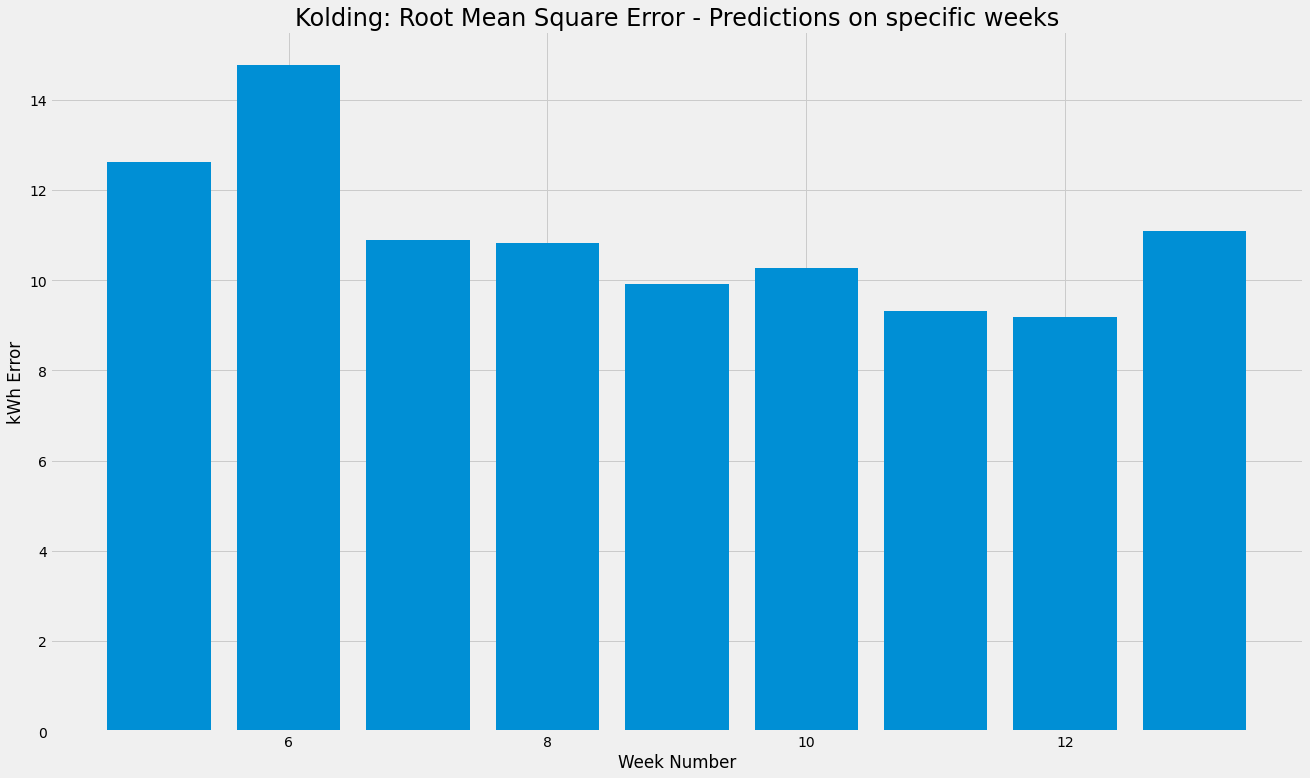

In [96]:
plt.bar(pred_weeks, height=week_rmse)
plt.title('Kolding: Root Mean Square Error - Predictions on specific weeks', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Week Number')
plt.savefig('visuals/kolding_rmse_week.png', bbox_inches='tight')
plt.show()

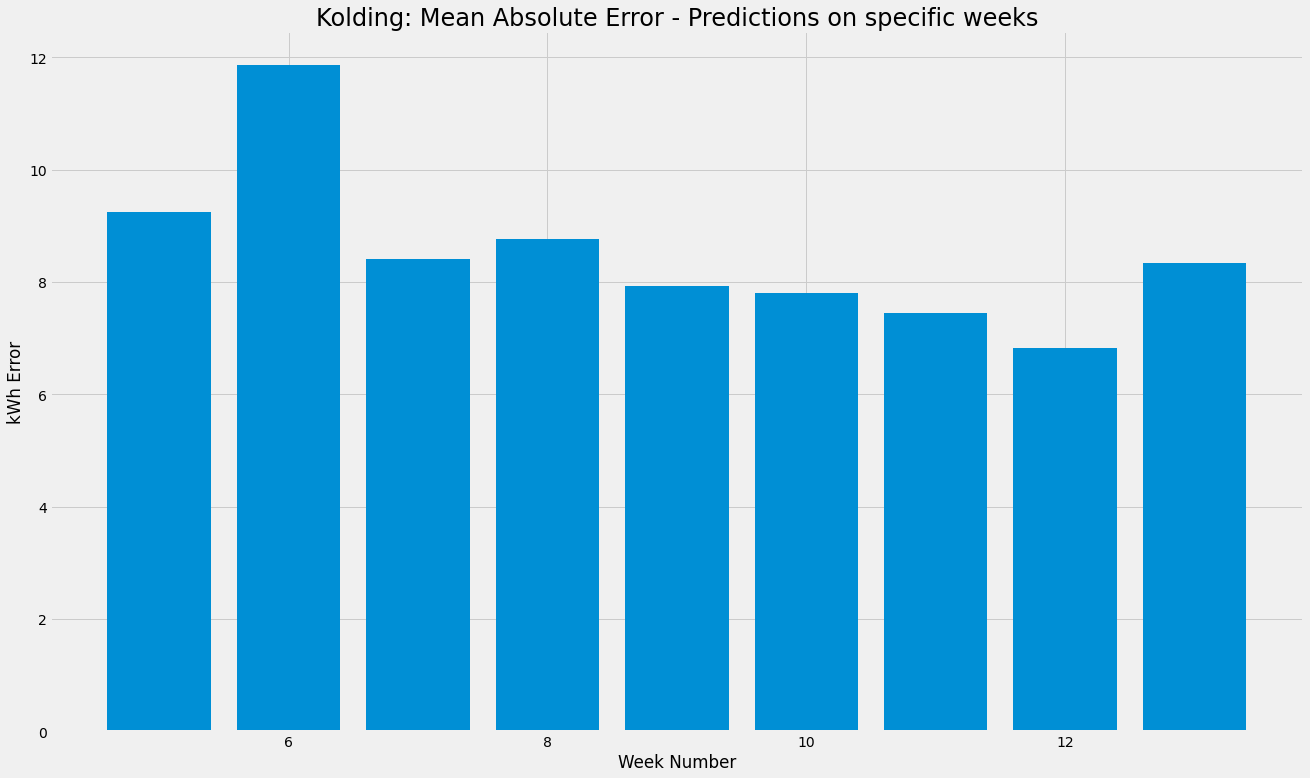

In [97]:
plt.bar(pred_weeks, height=week_mae)
plt.title('Kolding: Mean Absolute Error - Predictions on specific weeks', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Week Number')
plt.savefig('visuals/kolding_mae_week.png', bbox_inches='tight')
plt.show()

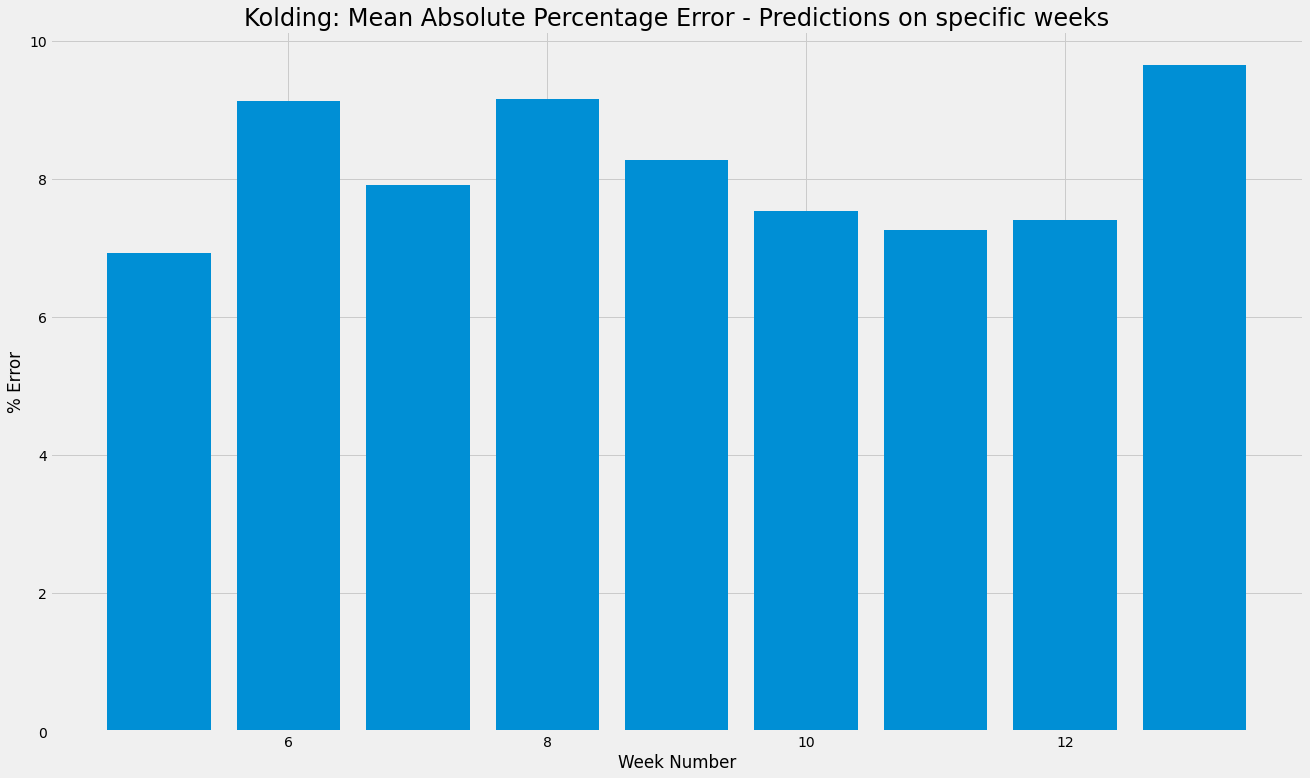

In [98]:
plt.bar(pred_weeks, height=week_mape)
plt.title('Kolding: Mean Absolute Percentage Error - Predictions on specific weeks', fontsize=24)
plt.ylabel('% Error')
plt.xlabel('Week Number')
plt.savefig('visuals/kolding_mape_week.png', bbox_inches='tight')
plt.show()

## Predicting hours of the day

In [59]:
pred_hours = pred_df.index.hour.unique().tolist()

for h in pred_hours:
    hour_df = pred_df[pred_df.index.hour == h]
    print(f'Hour: {h}')
    metrics(hour_df['True'].values, hour_df['Pred'].values)
    print('\n')

Hour: 1
MSE: 56.78978433186931
RMSE: 7.535899702880162
MAE: 5.987447160581784
MAPE: 8.32069957831438


Hour: 2
MSE: 42.97135731675112
RMSE: 6.555254176365026
MAE: 5.236279798887504
MAPE: 7.406283817076025


Hour: 3
MSE: 31.779055216037
RMSE: 5.637291478718924
MAE: 4.636770479638242
MAPE: 6.036630560083625


Hour: 4
MSE: 34.63253317258905
RMSE: 5.884941220827023
MAE: 4.472903734615094
MAPE: 5.372861676407687


Hour: 5
MSE: 42.82445716162963
RMSE: 6.544039819685516
MAE: 4.845593665923553
MAPE: 5.419539842894167


Hour: 6
MSE: 75.68757430164811
RMSE: 8.699860590931795
MAE: 6.71770514030362
MAPE: 6.734429544109155


Hour: 7
MSE: 130.69100923500085
RMSE: 11.432016848964178
MAE: 8.947764129095331
MAPE: 7.438008121030908


Hour: 8
MSE: 117.88959024082249
RMSE: 10.857697280769182
MAE: 8.828857947811514
MAPE: 7.415015402100414


Hour: 9
MSE: 180.32589438788975
RMSE: 13.42854773934582
MAE: 10.488916203691536
MAPE: 9.046515279573478


Hour: 10
MSE: 192.62272415696503
RMSE: 13.878858892465368
MAE:

In [85]:
hour_metrics = []

for h in pred_hours:
    hour_df = pred_df[pred_df.index.hour == h]
    hour_metrics.append(get_metrics(hour_df['True'].values, hour_df['Pred'].values))
    
hour_rmse = [rmse for (_, rmse, _, _) in hour_metrics]
hour_mae = [mae for (_, _, mae, _) in hour_metrics]
hour_mape = [mape for (_, _, _, mape) in hour_metrics]

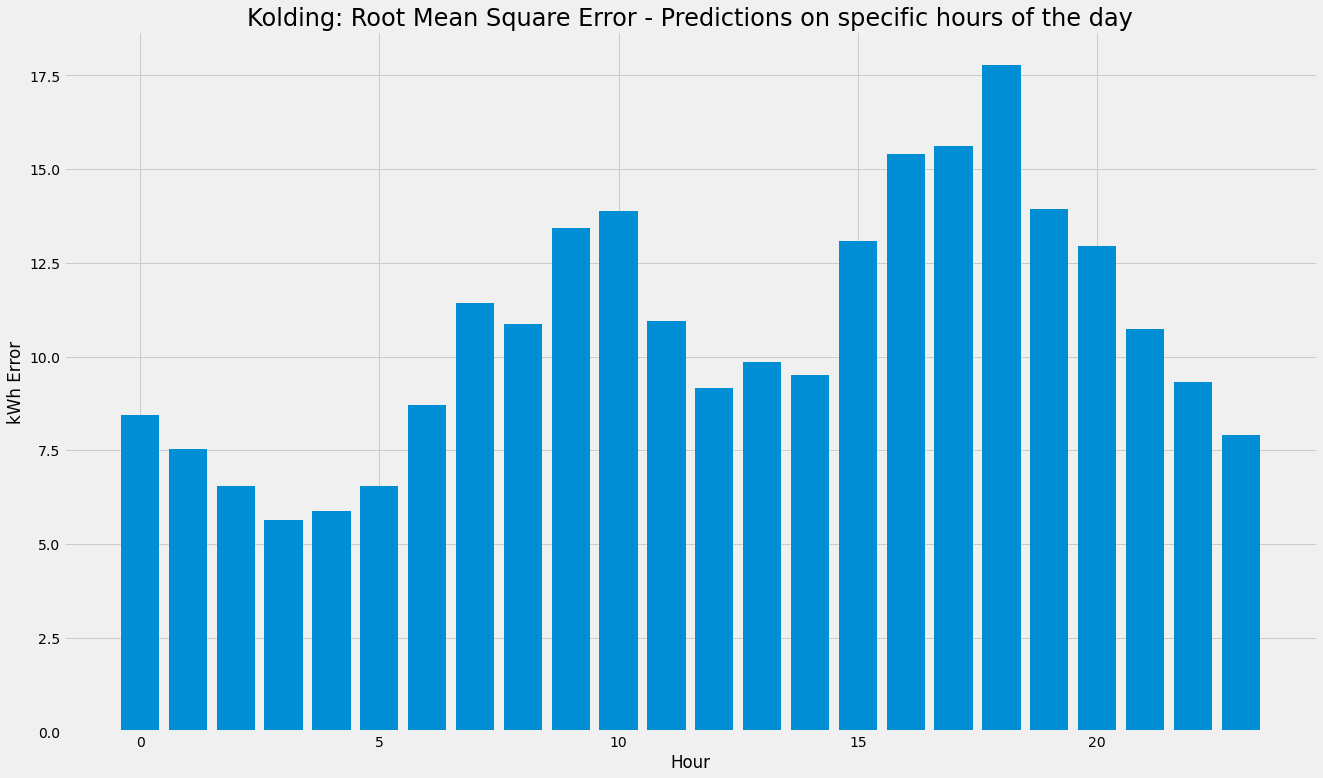

In [99]:
plt.bar(pred_hours, height=hour_rmse)
plt.title('Kolding: Root Mean Square Error - Predictions on specific hours of the day', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Hour')
plt.savefig('visuals/kolding_rmse_hour.png', bbox_inches='tight')
plt.show()

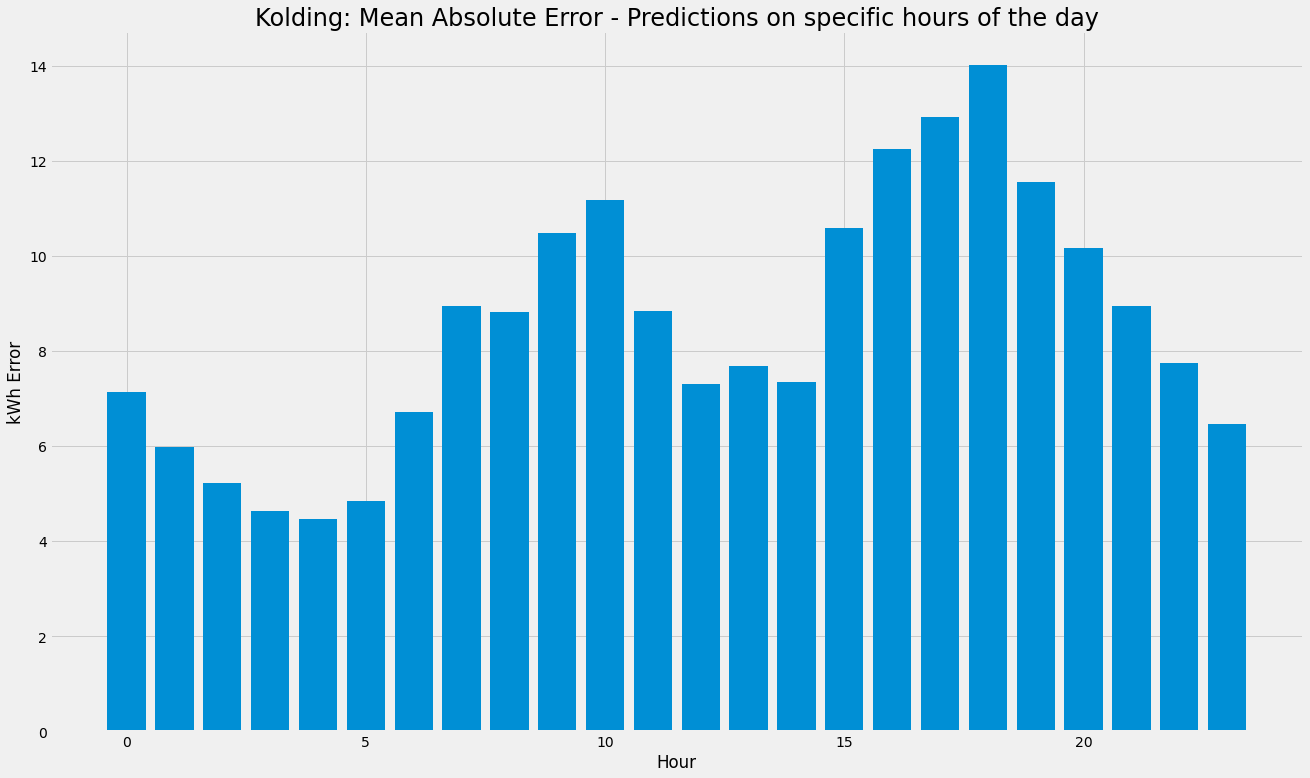

In [101]:
plt.bar(pred_hours, height=hour_mae)
plt.title('Kolding: Mean Absolute Error - Predictions on specific hours of the day', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Hour')
plt.savefig('visuals/kolding_mae_hour.png', bbox_inches='tight')
plt.show()

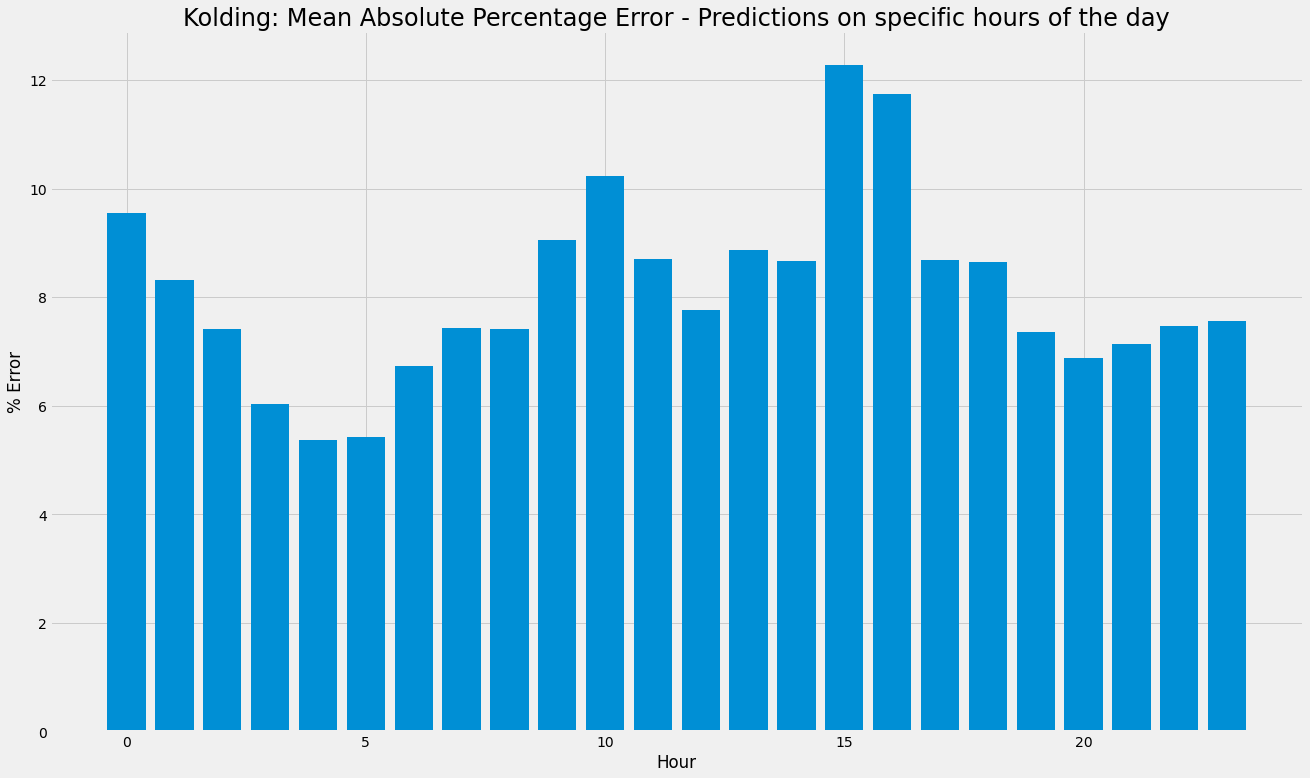

In [102]:
plt.bar(pred_hours, height=hour_mape)
plt.title('Kolding: Mean Absolute Percentage Error - Predictions on specific hours of the day', fontsize=24)
plt.ylabel('% Error')
plt.xlabel('Hour')
plt.savefig('visuals/kolding_mape_hour.png', bbox_inches='tight')
plt.show()